In [1]:
# help_0- 긍정
# help 0 - 부정
# help 1 -긍정
# help 1 - 부정

In [2]:
# 한글깨짐
import platform
import matplotlib.pyplot as plt

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

else:
    print(f'{os} is not set')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', family = 'Malgun Gothic')
rc('axes', unicode_minus = False)

import pandas as pd
from konlpy.tag import Mecab
from emoji import core
from gensim import corpora, models
from collections import Counter
import re
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

file_path ='best_real_last_reviews_with_group_help_ox.csv'
df = pd.read_csv(file_path)
df['help_cnt_yes']=df['help_cnt'].apply(lambda x:0 if x == 0 else 1)
df=df[(df['help_cnt_yes']==0) & (df['predicted_class']==0)] # 도움 0 &부정
df['review']=df['review'].str.replace(" +", " ")


def load_stopwords(filepath):
    with open(filepath, 'r', encoding='cp949') as file:
        stopwords = file.read().strip().split(',')
        return set(stopwords)
    
def clean_text(text):
  text= core.replace_emoji(text,replace='')
  text=re.sub(r'[^가-힣0-9\.]',' ',text) # 알파벳, 숫자, 마침
  text=re.sub(r'\.+','.',text) # 연속된 마침표
  text=re.sub(r'\n',' ',text) # 줄바꿈 문자
  text=re.sub(r'^[.]|[.]$',' ',text)

  return text.strip()

def remove_stopwords(text, stopwords):
    words = text.split()  # 텍스트를 공백 기준으로 분할
    filtered_words = [word for word in words if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_words)
    
stopwords = load_stopwords('../data/stopwords.txt')

df['review']=df['review'].apply(clean_text)

df['review']=df['review'].apply(lambda x : remove_stopwords(x,stopwords))

In [5]:
tokenized_docs = [mecab.pos(review) for review in df['review']]
tokenized_docs = [[word[0] for word in doc 
                   if word[0] not in stopwords and len(word[0]) > 1 and (word[0] not in ['생각','구매','신발','유면','원대', '대부분', '애용','해용', '산거','신한','신음','다운','일가','만한','이만', '애신','이용','응기','행력','은지','경우','해유','나용','니더', '구여','이면','여요','애요','아이오']) 
                   and (word[1] in ('NNG','VA','XR','SL')) ] for doc in tokenized_docs]

token_counts = Counter(word for doc in tokenized_docs for word in doc)
token_df = pd.DataFrame(token_counts.items(), columns=['Morpheme', 'Frequency'])

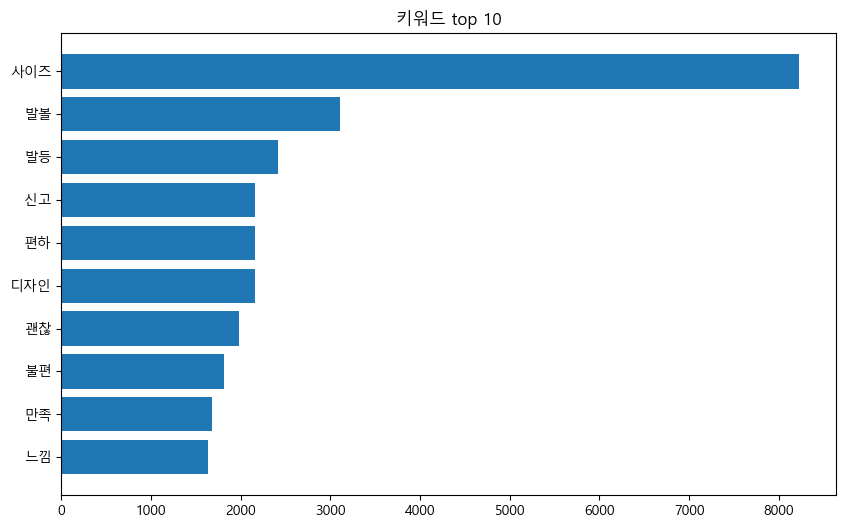

In [6]:
sort_token=token_df.sort_values(by='Frequency',ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(sort_token['Morpheme'],sort_token['Frequency'])
plt.title('키워드 top 10')
plt.gca().invert_yaxis() # y축 반전
plt.show()

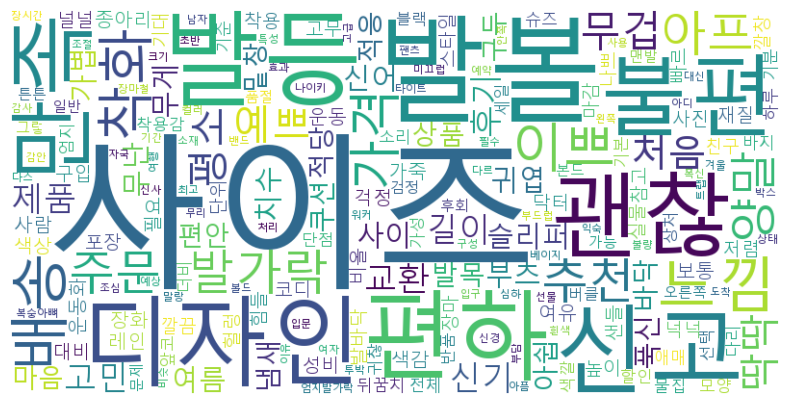

In [7]:
font_path='C:/Windows/Fonts/malgun.ttf'
# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path=font_path, width = 800, height = 400, background_color ='white').generate_from_frequencies(token_counts)

# 워드클라우드 보여주기
plt.figure(figsize=(10, 5))  # 크기 조정
plt.imshow(wordcloud, interpolation="bilinear")  # 이미지 표시
plt.axis("off")  # 축 제거
plt.show();

In [8]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(doc) for doc in tokenized_docs]
columns_as_lists = tokenized_docs

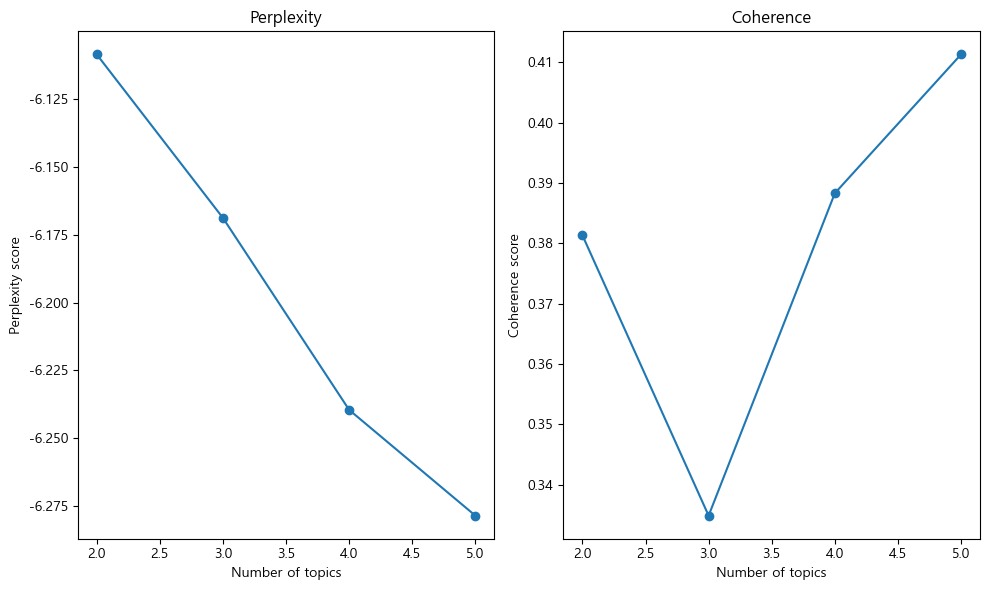

In [9]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


start_topic = 2
end_topic = 5
step = 1
topic_range = range(start_topic, end_topic + 1, step)

# Perplexity 계산
perplexity_values = []
for i in topic_range:
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=id2word)
    perplexity_values.append(ldamodel.log_perplexity(corpus)) 

# Coherence 계산
coherence_scores = []
for i in topic_range:
    lda_model = LdaModel(corpus, num_topics=i, id2word=id2word, passes=15)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=columns_as_lists, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)


fig, axes = plt.subplots(1, 2, figsize=(10, 6))
x = topic_range
plt.rcParams['axes.unicode_minus'] = False

# Perplexity subplot
axes[0].plot(x, perplexity_values, marker='o')
axes[0].set_xlabel('Number of topics')
axes[0].set_ylabel('Perplexity score') 
axes[0].set_title('Perplexity') 


# Coherence subplot
axes[1].plot(topic_range, coherence_scores, marker='o')
axes[1].set_xlabel('Number of topics')
axes[1].set_ylabel('Coherence score')
axes[1].set_title('Coherence')


plt.tight_layout()
plt.show()

In [10]:
optimal_co = topic_range[coherence_scores.index(max(coherence_scores))]
print("최적토픽 수 : ", optimal_co)

최적토픽 수 :  5


In [11]:
lda_model = models.LdaModel(corpus, # 말뭉치
                            num_topics=optimal_co, # 최적의 주제수
                            id2word=id2word, # 단어사전
                            #chunksize=20, # 각 학습 단계에서 사용하는 문서의 수
                            #passes=15, # 말뭉치 반복 횟수
                            #iterations=100, # 각 문서에 대해 LDA 모델 반복 횟수
                            per_word_topics=True) # 각 단어에 대한 토픽 정보 저장

In [12]:
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}") # 키워드 가중치, 키워드

Topic 0: 0.045*"아프" + 0.044*"이쁘" + 0.042*"슬리퍼" + 0.040*"가격" + 0.039*"편하" + 0.033*"발가락" + 0.027*"괜찮" + 0.023*"착화" + 0.019*"저렴" + 0.019*"딱딱"
Topic 1: 0.043*"만족" + 0.033*"귀엽" + 0.030*"배송" + 0.028*"양말" + 0.028*"괜찮" + 0.023*"디자인" + 0.022*"신기" + 0.019*"무난" + 0.018*"바운스" + 0.018*"알파"
Topic 2: 0.046*"디자인" + 0.038*"신고" + 0.034*"예쁘" + 0.032*"딱딱" + 0.031*"양말" + 0.028*"불편" + 0.025*"착화" + 0.023*"마음" + 0.019*"무겁" + 0.019*"닥터"
Topic 3: 0.243*"사이즈" + 0.054*"발볼" + 0.036*"주문" + 0.035*"평소" + 0.033*"추천" + 0.018*"길이" + 0.017*"신어" + 0.016*"편하" + 0.016*"교환" + 0.014*"후기"
Topic 4: 0.119*"발등" + 0.065*"발볼" + 0.048*"느낌" + 0.019*"사이즈" + 0.015*"괜찮" + 0.015*"사람" + 0.015*"가죽" + 0.014*"편안" + 0.012*"쿠션" + 0.011*"가능"


In [13]:
# dominant topic and its percentage contribution in each document

def topic_sentences(ldamodel=None, corpus=None, texts=None, df=None):
    topic_list = []

    # 문서별 토픽 할당
    for n in range(len(corpus)):
        doc_topic = ldamodel.get_document_topics(corpus[n], minimum_probability=0.0)
        doc_topic = sorted(doc_topic, key=lambda x: x[1], reverse=True)
        topic_most_pr = doc_topic[0][0]
        topic_pr = doc_topic[0][1]
        
        # 키워드 추출
        wp = ldamodel.show_topic(topic_most_pr)
        topic_keywords = ", ".join([word for word, prop in wp])
        
        topic_list.append([n, topic_most_pr, topic_pr, topic_keywords])
    
  
    topic_df = pd.DataFrame(topic_list, columns=['document_num', 'Dominant_Topic', 'Percentage', 'Keywords'])
    topic_df = topic_df.set_index('document_num')
    
    
    df = df.reset_index(drop=True)
    result_df = topic_df.join(df[['review']], how='inner')

    # 옵션 설정: 최대 컬럼 너비
    pd.set_option('display.max_colwidth', 1000)

    return result_df.reset_index(drop=True)


topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

topic_df.head()

,Dominant_Topic,Percentage,Keywords,review
0,0,0.200000,"아프, 이쁘, 슬리퍼, 가격, 편하, 발가락, 괜찮, 착화, 저렴, 딱딱",일까요 저는 이게 밯 뒷꿈치가 아파요 신을때마다 늘 까져요
1,4,0.649641,"발등, 발볼, 느낌, 사이즈, 괜찮, 사람, 가죽, 편안, 쿠션, 가능",샌들 중에 발이 잘 들어나지 않는걸 선호하는데 좋은거 같아요. 안신어보긴 했는데 뒤꿈치 고정부분이 약한거 같아서 조심히 신어야 할 거 같네여
2,2,0.556270,"디자인, 신고, 예쁘, 딱딱, 양말, 불편, 착화, 마음, 무겁, 닥터",보기엔 특이하고 예쁜데 신고 나갔다가 앞발가락이 몇번이나 튀어나오던지 불편했어요. 예쁜데 그부분이 아쉽네요
3,1,0.599804,"만족, 귀엽, 배송, 양말, 괜찮, 디자인, 신기, 무난, 바운스, 알파",일깨요 저눈 이게 뒷꿈치가 아파요 늘 신을 때마다 발이 까집니다
4,3,0.480091,"사이즈, 발볼, 주문, 평소, 추천, 길이, 신어, 편하, 교환, 후기",여성용은 250까지 안나와서 260인 저는 어쩔 수 남성용을 시켰답니다. 남성용이라 그런지 발목 쪽이 커서 잘못하면 벗겨질 같아요. 예쁘고 푹신푹신해서 좋아요


In [14]:
# topic 별 가장 대표하는 review
representative_sen=topic_df.groupby('Dominant_Topic')['Percentage'].idxmax()

topic_df.loc[representative_sen]

,Dominant_Topic,Percentage,Keywords,review
17566,0,0.949374,"아프, 이쁘, 슬리퍼, 가격, 편하, 발가락, 괜찮, 착화, 저렴, 딱딱",슬리퍼가 생각보다 무겁고 입구도 좁아서 한여름에는 땀이 찰거 같고 슬리퍼는 만족스럽지만 포장이 신발 박스에 비닐로만 포장되어와서 신발 박스가 찢어져서 도착했네요 다음에는 비닐 포장이 아니라 박스로 포장해서 보내주셨으면 좋겠네요
14008,1,0.932043,"만족, 귀엽, 배송, 양말, 괜찮, 디자인, 신기, 무난, 바운스, 알파",이쁘고 키높이도 적당하고 좋습니다. 맨발에 더 적절한 착화감인데 전 양말 신고 신어야 해서 미끄럽긴 하네요. 가격대비 좋다고는 못느끼겠지만 우선은 만족합니다
1179,2,0.945189,"디자인, 신고, 예쁘, 딱딱, 양말, 불편, 착화, 마음, 무겁, 닥터",적당히 격식 있어보이고 여성스럽게 연출할 수 있는 구두가 필요했는데 딱이에요 발이 아프진 않지만 플랫 슈즈 특성상 바닥의 것이 느껴져서 안에 폭신한 깔창 깔고 신으시는 걸 추천드리고 싶네요. 마음에 들어요
2728,3,0.954740,"사이즈, 발볼, 주문, 평소, 추천, 길이, 신어, 편하, 교환, 후기",발볼은 넓고 길이는 짧은 여자 후기입니다 아디다스.230 반스 컨버스 230 나이키 우먼스 235 구두는 240 신습니다 발볼너비가 어떻냐에 신발사이즈가 달라지는데 크게 시키셔도 될거같아요 저는 240시켰는데 길이는 남긴한데 통은 괜찮아요 230 시켰으면 작거나 여유가 없을거 같아요 여유있게 시키세요
19811,4,0.951729,"발등, 발볼, 느낌, 사이즈, 괜찮, 사람, 가죽, 편안, 쿠션, 가능",발볼 넓고 발등 높은 사람에게 비추 입니다 발볼 넓게 나왔대서 정사이즈 구매했는데 꽉껴요 버클도 너무너무 불편함. 반품할려다가 버클 구멍하나 뚫으면 괜찮겠지 했는데도 너무너무 꽉끼고 불편하네용. 쿠션은 푹신해요 발볼없는 사람에게 추천합니다


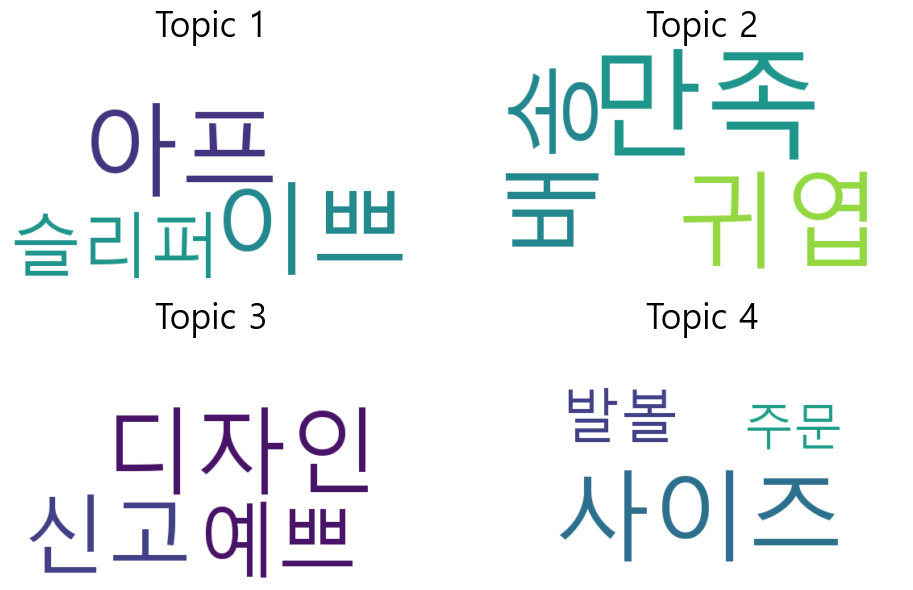

In [15]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 워드 클라우드 생성( 가중치 시각화)
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
wordcloud = WordCloud(font_path=font_path,width=500, height=300, background_color='white')

for i, ax in enumerate(axes.flatten()):
    if i >= len(lda_model.get_topics()): 
        ax.axis('off')
        continue

    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i, topn=3))  # 각 토픽의 상위 3개 키워드 사용
    wordcloud.generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic ' + str(i+1), fontdict=dict(size=25))
    ax.axis('off')

plt.tight_layout()
plt.show()

C:\Users\jk032\AppData\Local\Temp\ipykernel_25284\3904257.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)


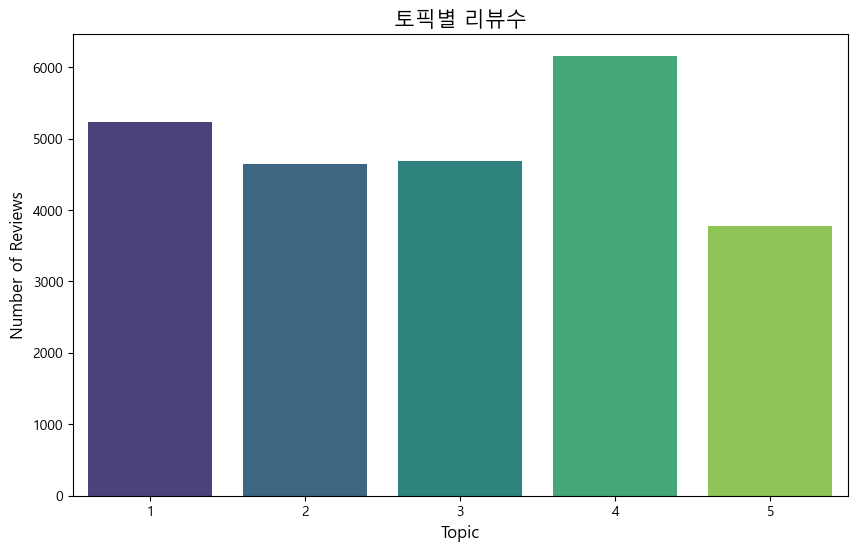

In [16]:
topic_df = topic_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review'], df=df)

# 토픽별 리뷰 수
topic_counts = topic_df['Dominant_Topic'].value_counts().sort_index()

# 막대 차트 시각화
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis', ax=ax)
ax.set_title('토픽별 리뷰수', fontsize=15)
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)

ax.set_xticks(range(len(topic_counts)))
ax.set_xticklabels(range(1, len(topic_counts) + 1))

plt.xticks(rotation=0)
plt.show()

In [17]:
#pyLDA
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis,local=False)

In [18]:
pyLDAvis.save_html(vis, 'lda_visualization_help0neg.html')
# file:///C:/Users/jk032/zerobase/mlproject/lda_visualization_help0neg.html
